In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

# URL Download
import csv
import io
import urllib.request
import requests

# Read in data

In [6]:
!ls

 1.1_B_Theft_DataCleaning.ipynb
 1.2_B_Theft_AllocationToBezirke.ipynb
 1.2_B_Theft_EDA.ipynb
 1.3.1_B_Theft_Modelling.ipynb
 1.3.2_B_Theft_Modelling_Added_Features.ipynb
 1.3.3_B_Theft_Modelling_Clean_Reported_Date.ipynb
 1.4_B_Theft_Production_Test.ipynb
 2_B_Sharing_Location_EDA.ipynb
 4_B_Accident_EDA.ipynb
'4 Bike Accident.ipynb'
 5_Streamlit_mapping.ipynb
 B_Theft_Modelling_OLD_IterativeApproach.ipynb


In [28]:
df_theft = pd.read_csv("../data/bike_theft_cleaned.csv")
df_theft.set_index("date_reported", inplace=True)

In [29]:
df_theft

,total,total_moving_average
date_reported,,
2021-01-01,4.0,54.000000
2021-01-02,7.0,54.000000
2021-01-03,3.0,4.666667
2021-01-04,21.0,10.333333
2021-01-05,31.0,18.333333
...,...,...
2022-03-11,53.0,59.333333
2022-03-12,40.0,50.666667
2022-03-13,42.0,45.000000


# Group theft data by Bezirk and date_reported

In [322]:
# Group dataframe by date and LOR
df_theft = df_theft.pivot_table(index = "date_reported", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft.fillna(value = 0, inplace=True)

In [323]:
# create "total" column which sums up data for each day
df_theft["total"] = df_theft.sum(axis=1)


df_theft.shape

(424, 13)

In [326]:
df_theft = df_theft[["total"]]

In [283]:
# as the last step we rename the date column to match the name in df_feat
df_theft = df_theft.rename(columns={"date_reported": "date"})

In [346]:
df_theft.index.min(), df_theft.index.max()

('2021-01-01', '2022-02-28')

In [345]:
pd.date_range(start = df_theft.index.min(), end = df_theft.index.max()).difference(df_theft.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [343]:
df_theft.index.min()

'2021-01-01'

In [327]:
def calculate_rolling_average(df, window_size):
    fill_value = df["total"][-window_size:].mean()
    df["total_moving_average"] = df["total"].rolling(window = window_size, center = False).mean().fillna(fill_value)
    return df

# Calculate Rolling Average

In [328]:
df_theft = calculate_rolling_average(df_theft, 5)

In [329]:
df_theft.head()

Bezirk,total,total_moving_average
date_reported,,
2021-01-01,4.0,39.0
2021-01-02,7.0,39.0
2021-01-03,3.0,39.0
2021-01-04,21.0,39.0
2021-01-05,31.0,13.2


# Train-test-split

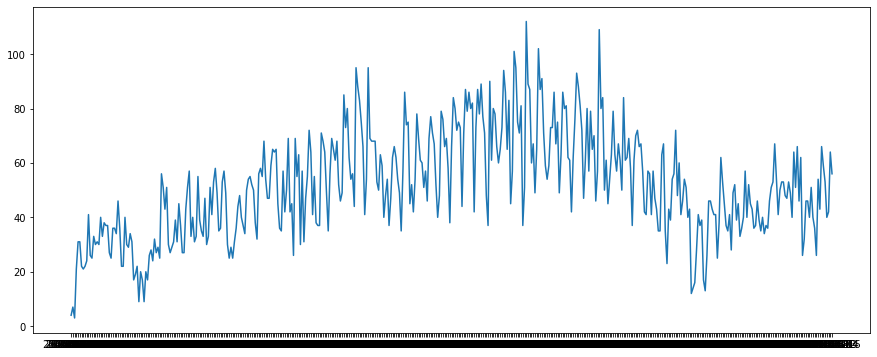

In [30]:
plt.figure(figsize = (15, 6))
plt.plot(df_theft["total"]);

In [31]:
int(len(df_theft) * 0.8)

351

In [32]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset.iloc[i: i + window_size])
    y.append(dataset["total"][i + window_size + future_horizon -1 : i + window_size  + future_horizon, ])

  return np.array(X), np.array(y)

In [33]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_theft.iloc[:339, :])
X_test, y_test = get_X_y(window_size, future_horizon, df_theft.iloc[339:, :])

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((307, 31, 2), (307, 1), (68, 31, 2), (68, 1))

In [35]:
es = callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

In [36]:
def create_opt_model(): 
    """
    Creates the finetuned model selected in B_Theft_Modelling
    Outputs models, that needs to be compiled and fit"""
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

# Baseline model (last observation)

In [37]:
X_train.shape

(307, 31, 2)

In [38]:
y_pred_base = X_test[:,-1,0]
y_pred_base.shape

(68,)

In [39]:
y_test.shape

(68, 1)

In [40]:
mean_absolute_percentage_error(y_test, y_pred_base)*100

22.003712509904947

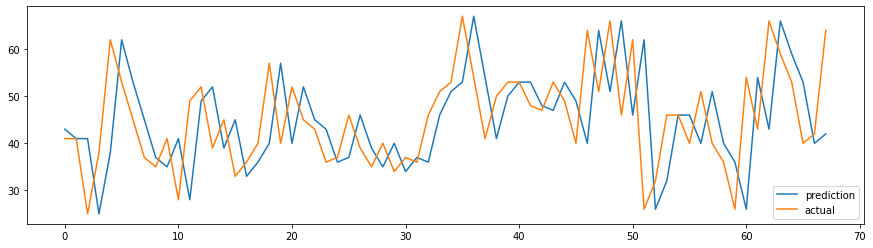

In [41]:
plt.figure(figsize= (15, 4))
plt.plot(y_pred_base, label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

# Feed into model

In [42]:
opt_model = create_opt_model()
opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")
opt_model.fit(X_train, 
                  y_train, 
                  batch_size = 8, 
                  epochs = 300, 
                  verbose = 1, 
                  callbacks = [es], 
                  validation_split = 0.2)

Epoch 1/300


2022-03-16 19:33:42.633071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 19:33:42.633207: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 19:33:42.633260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-16 19:33:42.633862: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31/31 [==============================] - 3s 33ms/step - loss: 3102.2029 - mean_absolute_percentage_error: 94.8176 - val_loss: 3852.2197 - val_mean_absolute_percentage_error: 93.0520
Epoch 2/300
31/31 [==============================] - 1s 18ms/step - loss: 2761.4275 - mean_absolute_percentage_error: 87.4144 - val_loss: 3517.1243 - val_mean_absolute_percentage_error: 88.4053
Epoch 3/300
31/31 [==============================] - 1s 18ms/step - loss: 2557.2473 - mean_absolute_percentage_error: 82.8978 - val_loss: 3346.9067 - val_mean_absolute_percentage_error: 85.9549
Epoch 4/300
31/31 [==============================] - 1s 18ms/step - loss: 2445.8020 - mean_absolute_percentage_error: 80.2655 - val_loss: 3222.1011 - val_mean_absolute_percentage_error: 84.1153
Epoch 5/300
31/31 [==============================] - 1s 18ms/step - loss: 2348.2700 - mean_absolute_percentage_error: 78.0020 - val_loss: 3108.1279 - val_mean_absolute_percentage_error: 82.4015
Epoch 6/300
31/31 [=======================

31/31 [==============================] - 1s 18ms/step - loss: 651.9104 - mean_absolute_percentage_error: 37.1651 - val_loss: 897.1478 - val_mean_absolute_percentage_error: 37.3343
Epoch 44/300
31/31 [==============================] - 1s 18ms/step - loss: 653.9600 - mean_absolute_percentage_error: 37.0017 - val_loss: 869.2546 - val_mean_absolute_percentage_error: 36.5002
Epoch 45/300
31/31 [==============================] - 1s 18ms/step - loss: 624.2947 - mean_absolute_percentage_error: 37.1458 - val_loss: 844.7547 - val_mean_absolute_percentage_error: 35.7528
Epoch 46/300
31/31 [==============================] - 1s 19ms/step - loss: 637.7136 - mean_absolute_percentage_error: 37.3953 - val_loss: 819.3571 - val_mean_absolute_percentage_error: 34.9624
Epoch 47/300
31/31 [==============================] - 1s 18ms/step - loss: 619.9518 - mean_absolute_percentage_error: 37.1705 - val_loss: 796.8366 - val_mean_absolute_percentage_error: 34.2477
Epoch 48/300
31/31 [============================

31/31 [==============================] - 1s 19ms/step - loss: 309.5693 - mean_absolute_percentage_error: 26.4140 - val_loss: 310.0235 - val_mean_absolute_percentage_error: 20.5065
Epoch 86/300
31/31 [==============================] - 1s 19ms/step - loss: 297.9157 - mean_absolute_percentage_error: 25.6108 - val_loss: 304.4461 - val_mean_absolute_percentage_error: 20.3202
Epoch 87/300
31/31 [==============================] - 1s 19ms/step - loss: 287.7038 - mean_absolute_percentage_error: 26.3931 - val_loss: 299.0052 - val_mean_absolute_percentage_error: 20.1512
Epoch 88/300
31/31 [==============================] - 1s 19ms/step - loss: 281.4518 - mean_absolute_percentage_error: 25.3246 - val_loss: 293.4632 - val_mean_absolute_percentage_error: 19.9598
Epoch 89/300
31/31 [==============================] - 1s 19ms/step - loss: 282.8822 - mean_absolute_percentage_error: 26.1925 - val_loss: 288.1052 - val_mean_absolute_percentage_error: 19.7547
Epoch 90/300
31/31 [============================

In [43]:
opt_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 103.1440 - mean_absolute_percentage_error: 20.1955


[103.14401245117188, 20.195472717285156]

In [44]:
opt_model.predict(X_test).shape

(68, 1)

In [45]:
y_test.shape

(68, 1)

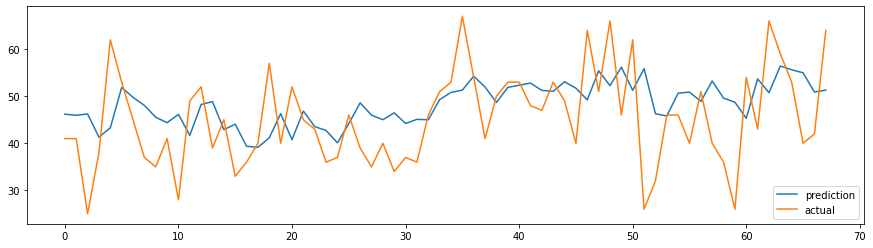

In [46]:
plt.figure(figsize= (15, 4))
plt.plot(opt_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "actual")
plt.legend();

In [48]:
plot_df = pd.DataFrame(opt_model.predict(X_test))

In [54]:
plot_df["date"] = df_theft.index[-68:]


In [66]:
plot_df

,0,date
0,46.194679,2022-01-07
1,45.957027,2022-01-08
2,46.243172,2022-01-09
3,41.314892,2022-01-10
4,43.295887,2022-01-11
...,...,...
63,56.429100,2022-03-11
64,55.627563,2022-03-12
65,54.981552,2022-03-13
66,50.892799,2022-03-14


In [67]:
plot_df.rename(columns = {0: "total"}, inplace=True)

In [59]:
plot_df["date"] = pd.to_datetime(plot_df["date"])

In [ ]:
plt.figure(figsize= (15, 4))
plt.plot_date(y = plot_df["total"], x = plot_df["date"],fmt="b-", label= "predicted")
plt.plot_date(y = y_test, x = plot_df["date"], fmt ="r-", label = "actual")
plt.legend();